## indlæs, lav graf

In [3]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# 1. Læs data
df = pd.read_csv("data/overview.csv")
movies_df = pd.read_csv("data/movies.csv")

# 2. Rens cast-kolonne
df["cast_names"] = df["cast_names"].fillna("").astype(str)

# 3. Lav cast_list
df["cast_list"] = df["cast_names"].apply(
    lambda s: [c.strip() for c in s.split("|") if c.strip() != ""]
)

# 4. Join overview med movies
merged_df = df.merge(movies_df[["movieId", "genres"]], on="movieId", how="left")

# 5. Split genres til liste
merged_df["genres"] = merged_df["genres"].fillna("")
merged_df["genre_list"] = merged_df["genres"].apply(
    lambda s: [g.strip() for g in s.split("|") if g.strip() != ""]
)
# tæl forekomster af hver genre


# 6. Filtrér på en bestemt genre (præcist match)
target_genre = "Action"   # ← Skift her


genre_df = merged_df[merged_df["genre_list"].apply(lambda lst: target_genre in lst) ].copy()

# tag links csv filen og sørg for den kun indeholder film fra genre_df
#links_df = pd.read_csv("data/links.csv")
#links_df = links_df[ links_df["movieId"].isin( genre_df["movieId"] ) ]
#print(links_df.head())
# giv mig links_df som csv eksporter
#links_df.to_csv("data/links_action.csv", index=False)
# 7. Tjek resultat
#print(genre_df.head())
# antal film før filtrering
print("Antal film i alt:", len(merged_df))
print("Antal film i genren:", len(genre_df))
# vis genre kolonenn
#print(merged_df[ "genre_list"].head())

Antal film i alt: 86411
Antal film i genren: 9553


In [4]:
all_genres = list(itertools.chain.from_iterable(merged_df["genre_list"]))
genre_counts = pd.Series(all_genres).value_counts()
print("Genre counts:")
print(genre_counts)


Genre counts:
Drama                 33647
Comedy                22798
Thriller              11668
Romance               10159
Action                 9553
Documentary            9232
Horror                 8565
(no genres listed)     7059
Crime                  6912
Adventure              5345
Sci-Fi                 4844
Animation              4571
Children               4365
Mystery                3967
Fantasy                3819
War                    2297
Western                1690
Musical                1054
Film-Noir               353
IMAX                    195
Name: count, dtype: int64


In [5]:
import itertools
import networkx as nx

# 4. Opret graf
G = nx.Graph()

for cast in genre_df["cast_list"]:
    # Tilføj noder (skuespillere)
    for actor in cast:
        if actor not in G:
            G.add_node(actor)
    
    # Tilføj kanter for alle par af skuespillere i samme film
    for a, b in itertools.combinations(cast, 2):
        if G.has_edge(a, b):
            # øg vægten hvis kanten allerede findes
            G[a][b]["weight"] += 1
        else:
            G.add_edge(a, b, weight=1)

# 5. Fjern isolerede noder (valgfrit, men anbefales)
H = G.copy()
isolated = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(isolated)

# Info
print("Original graf: {} noder, {} kanter".format(G.number_of_nodes(), G.number_of_edges()))
print("Renset graf uden isolerede noder: {} noder, {} kanter".format(H.number_of_nodes(), H.number_of_edges()))


Original graf: 45153 noder, 378226 kanter
Renset graf uden isolerede noder: 45147 noder, 378226 kanter


## Graf undersøgelse

- Degree Distribtuion
- Hvem har lavest og højest degree distribution
- Max/min degree

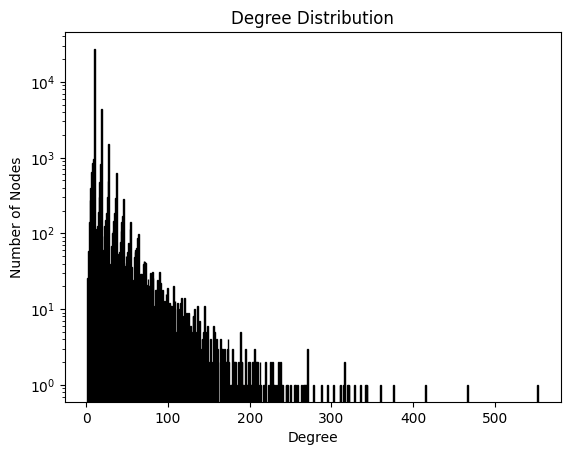

In [13]:
# Degree distribution plot
degrees = [d for n, d in H.degree()]
plt.hist(degrees, bins=range(1, max(degrees)+1), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.yscale('log')  # Log-skala for bedre visualisering
plt.show()

In [14]:
# Højst og lavest degree
degree_sequence = sorted(H.degree(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter degree:")
for actor, degree in degree_sequence[:5]:
    print(f"{actor}: {degree}")
print("\nBottom 5 skuespillere efter degree:")
for actor, degree in degree_sequence[-5:]:
    print(f"{actor}: {degree}")


Top 5 skuespillere efter degree:
Jackie Chan: 553
Bruce Willis: 466
Danny Trejo: 415
Samuel L. Jackson: 375
Eric Roberts: 360

Bottom 5 skuespillere efter degree:
Brian Sy: 1
Ron Arthurs: 1
Simon Arblaster: 1
Bear Grylls: 1
Jason Derek Prempeh: 1


In [15]:
# Max og min degree
max_degree_actor, max_degree = degree_sequence[0]
min_degree_actor, min_degree = degree_sequence[-1]
print("\nSkuespiller med højst degree: {} ({})".format(max_degree_actor, max_degree))
print("Skuespiller med lavest degree: {} ({})".format(min_degree_actor, min_degree))


Skuespiller med højst degree: Jackie Chan (553)
Skuespiller med lavest degree: Jason Derek Prempeh (1)


## Community

### Community TF-IDF 

- Modularity
- Structural Communities (Louvain algorithm) to find optimal structural communities
- Purity metrics - Community purity


In [21]:
# Find GCC
components = nx.connected_components(H)
gcc_nodes = max(components, key=len)

# Lav en subgraf for GCC
H_gcc = H.subgraph(gcc_nodes).copy()

print(f"Størrelse af GCC: {H_gcc.number_of_nodes()} nodes, {H_gcc.number_of_edges()} edges")

# Kør Louvain på GCC
from community import community_louvain

partition_gcc = community_louvain.best_partition(H_gcc, weight="weight")

# Antal communities
num_comms = len(set(partition_gcc.values()))
print(f"Louvain på GCC fandt {num_comms} communities")

# Modularity
Q = community_louvain.modularity(partition_gcc, H_gcc)
print(f"Modularity på GCC: {Q:.4f}")
from collections import Counter

community_sizes_gcc = Counter(partition_gcc.values())

# Sorter fra største til mindste
for comm, size in community_sizes_gcc.most_common(20):
    print(f"Community {comm}: {size} skuespillere")


Størrelse af GCC: 42658 nodes, 368323 edges
Louvain på GCC fandt 142 communities
Modularity på GCC: 0.7343
Community 65: 8664 skuespillere
Community 54: 6028 skuespillere
Community 3: 2765 skuespillere
Community 9: 2429 skuespillere
Community 11: 2087 skuespillere
Community 25: 2040 skuespillere
Community 32: 1462 skuespillere
Community 4: 1402 skuespillere
Community 47: 1198 skuespillere
Community 63: 1084 skuespillere
Community 43: 1067 skuespillere
Community 17: 1012 skuespillere
Community 15: 936 skuespillere
Community 73: 887 skuespillere
Community 45: 867 skuespillere
Community 28: 803 skuespillere
Community 31: 729 skuespillere
Community 66: 686 skuespillere
Community 34: 644 skuespillere
Community 19: 441 skuespillere


In [ ]:
import networkx as nx
from collections import defaultdict

community_names = {}
community_hubs = {}

# Find top-1 hubs + navngiv
for comm in set(partition_gcc.values()):
    # noder i community
    nodes = [n for n, c in partition_gcc.items() if c == comm]
    sub = H_gcc.subgraph(nodes)
    
    # weighted degree
    degrees = sub.degree(weight="weight")
    
    # sortér efter degree (højeste først)
    top1 = sorted(degrees, key=lambda x: x[1], reverse=True)[:1]
    community_hubs[comm] = top1
    
    # lav community-navn ud fra top-1
    hub_names = [actor for actor, deg in top1]
    community_name = " - ".join(hub_names)
    
    community_names[comm] = community_name

# Udskriv de 20 største communities med auto-navn
from collections import Counter
sizes = Counter(partition_gcc.values())

print("Top 20 communities med navne:")
for comm, size in sizes.most_common(20):
    print(f"Community {comm} (size {size}) → {community_names[comm]}")


Top 20 communities med navne:
Community 65 (size 8664) → Bruce Willis
Community 54 (size 6028) → John Wayne
Community 3 (size 2765) → Jackie Chan
Community 9 (size 2429) → Nassar
Community 11 (size 2087) → Toshirō Mifune
Community 25 (size 2040) → Bud Spencer
Community 32 (size 1462) → Gerald Webb
Community 4 (size 1402) → Rodrigo Obregón
Community 47 (size 1198) → Viktor Verzhbitskiy
Community 63 (size 1084) → Lee Kyung-young
Community 43 (size 1067) → Jakob Eklund
Community 17 (size 1012) → Moussa Maaskri
Community 15 (size 936) → Casper Van Dien
Community 73 (size 887) → Grey DeLisle
Community 45 (size 867) → Kappei Yamaguchi
Community 28 (size 803) → Kevin Sorbo
Community 31 (size 729) → Bashar Rahal
Community 66 (size 686) → Petchtai Wongkamlao
Community 34 (size 644) → Sean Bean
Community 19 (size 441) → Debbie Rochon


In [43]:
movie_overview = dict(zip(genre_df["movieId"], genre_df["overview"]))
from collections import defaultdict

actor_movies = defaultdict(list)

for movie_id, cast in zip(genre_df["movieId"], genre_df["cast_list"]):
    for actor in cast:
        actor_movies[actor].append(movie_id)

print(actor_movies["Bruce Willis"])

[165, 544, 996, 1036, 1370, 1527, 1687, 1833, 1917, 2334, 4548, 6213, 7000, 7007, 7381, 32029, 32587, 53972, 54995, 71530, 74532, 81229, 91485, 96590, 96610, 97470, 100498, 101076, 103810, 113573, 114849, 127323, 157432, 160684, 175783, 183419, 184931, 193137, 194983, 207023, 209913, 217523, 221090, 232731, 241784, 254214, 260433, 262755, 266418, 267616, 268226, 271198, 274055, 274201, 275561, 276321, 276797, 278514, 280112, 281438, 281828, 282875, 286163]


In [44]:
from collections import defaultdict

community_corpus = defaultdict(list)

for actor, comm in partition_gcc.items():
    for movie_id in actor_movies.get(actor, []):
        overview = movie_overview.get(movie_id, "")
        if isinstance(overview, str) and len(overview.strip()) > 0:
            community_corpus[comm].append(overview)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

community_keywords = {}

for comm, docs in community_corpus.items():
    if len(docs) < 10:  # skip tiny communities
        continue
    
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names_out()
    
    avg_scores = tfidf.mean(axis=0).A1
    top_idx = avg_scores.argsort()[-15:][::-1]
    
    keywords = [features[i] for i in top_idx]
    community_keywords[comm] = keywords


In [46]:
top_communities = [65, 54, 3, 9, 11, 25, 32, 4, 47, 63]

for comm in top_communities:
    print(f"\nCommunity {comm}: {community_names[comm]}")
    print("Keywords:")
    print(", ".join(community_keywords.get(comm, ["No data"])))



Community 65: Bruce Willis
Keywords:
world, new, man, life, young, group, team, agent, war, save, family, city, time, police, mission

Community 54: John Wayne
Keywords:
war, man, gang, new, american, world, town, young, group, woman, help, secret, agent, british, finds

Community 3: Jackie Chan
Keywords:
martial, arts, master, gang, young, fu, hong, kong, kung, police, man, chinese, life, china, world

Community 9: Nassar
Keywords:
man, love, police, officer, young, family, life, father, son, india, cop, gangster, falls, gets, takes

Community 11: Toshirō Mifune
Keywords:
yakuza, japan, samurai, family, young, new, man, life, group, japanese, godzilla, time, war, world, gang

Community 25: Bud Spencer
Keywords:
man, agent, evil, gang, group, young, police, american, secret, new, war, gold, town, finds, fight

Community 32: Gerald Webb
Keywords:
earth, world, fight, new, team, way, family, planet, group, town, time, man, alien, life, stop

Community 4: Rodrigo Obregón
Keywords:
man, w

### Sentiment-analysis

In [86]:
import pandas as pd
import re
import numpy as np

# Load LabMT data
labmt = pd.read_csv("Data_Set_S1.txt", sep="\t")

# Dictionary: ord → happiness score
labmt_dict = dict(zip(
    labmt["word"].astype(str).str.lower(),
    labmt["happiness_average"]
))

def tokenize(text):
    return re.findall(r"[a-z']+", str(text).lower())



In [87]:
def labmt_sentiment(text, word_dict, lens=1.0, center=5.0):
    tokens = tokenize(text)
    scores = [word_dict[t] for t in tokens if t in word_dict]

    # fjern neutrale ord (fx "movie", "film", "time", "man"...)
    filtered = [s for s in scores if s < center - lens or s > center + lens]

    if not filtered:
        return None

    return float(np.mean(filtered))


In [92]:
reviews_df = pd.read_csv("data/reviews.csv")

reviews_df["sentiment"] = reviews_df["reviews"].apply(
    lambda text: labmt_sentiment(text, labmt_dict)
)

In [112]:
movie_sentiment = (
    reviews_df.groupby("movieId")["sentiment"].mean().to_dict()
)

# fjern alle NaN værdier
movie_sentiment = {m: s for m, s in movie_sentiment.items() if s == s}

print(movie_sentiment)


{6: 5.985784313725491, 10: 6.047540106951871, 15: 6.08057057057057, 20: 5.995, 23: 5.937377049180327, 42: 5.542574257425743, 44: 6.196753246753246, 70: 5.68012987012987, 71: 6.211860465116279, 76: 5.631764705882354, 110: 5.980392156862745, 112: 5.867795275590551, 145: 6.185849056603774, 151: 5.900046296296296, 153: 5.637021276595746, 160: 5.600196078431373, 163: 6.108823529411764, 165: 5.795878787878788, 168: 5.954120481927711, 170: 6.073488372093022, 172: 5.918780487804877, 173: 5.811851851851851, 185: 5.927333333333334, 198: 5.7438383838383835, 204: 5.5672093023255815, 208: 5.909861878453039, 227: 5.605714285714285, 236: 6.6033333333333335, 260: 6.144004329004329, 288: 5.62034090909091, 292: 5.726321839080461, 293: 6.014301075268817, 303: 5.854734299516909, 315: 6.017297297297297, 316: 6.0254128440366985, 327: 5.836111111111112, 338: 5.705921052631579, 349: 5.819368421052632, 353: 5.7126829268292685, 367: 6.1289898989899, 370: 6.123125, 377: 6.102978723404254, 379: 5.783863636363636,

In [115]:
import numpy as np

actor_sentiment = {}

for actor, movies in actor_movies.items():
    vals = []
    for m in movies:
        if m in movie_sentiment:
            if not np.isnan(movie_sentiment[m]):   # eksplicit nan-check
                vals.append(movie_sentiment[m])
    
    actor_sentiment[actor] = np.mean(vals) if len(vals) > 0 else None


In [116]:
print(actor_sentiment)

{'Al Pacino': 6.000904216808674, 'Robert De Niro': 6.107746603793114, 'Val Kilmer': 5.872872806507617, 'Jon Voight': 5.917035939048255, 'Tom Sizemore': 5.616373414193793, 'Diane Venora': 5.88775065339598, 'Amy Brenneman': 6.072112364759424, 'Ashley Judd': 5.865967320261439, 'Mykelti Williamson': 5.912512254901961, 'Wes Studi': 5.963240244643552, 'Jean-Claude Van Damme': 5.679333425116234, 'Powers Boothe': 5.857118465706505, 'Raymond J. Barry': 5.88712113402062, 'Whittni Wright': None, 'Ross Malinger': None, 'Dorian Harewood': None, 'Kate McNeil': None, 'Michael Gaston': 6.028803009575924, 'Audra Lindley': None, 'Brian Delate': None, 'Pierce Brosnan': 5.980795602975671, 'Sean Bean': 6.0049086160051734, 'Izabella Scorupco': 5.984600296093714, 'Famke Janssen': 5.861963313734188, 'Joe Don Baker': 5.912720030763303, 'Judi Dench': 5.939086239688026, 'Robbie Coltrane': 6.367007691332688, 'Tchéky Karyo': 5.850913677121115, 'Gottfried John': 6.047540106951871, 'Alan Cumming': 6.062641779433488,

In [117]:
from collections import defaultdict
import numpy as np

community_sentiment = defaultdict(list)

for actor, comm in partition_gcc.items():
    if actor_sentiment[actor] is not None:
        community_sentiment[comm].append(actor_sentiment[actor])

community_sentiment_mean = {
    comm: np.mean(vals) for comm, vals in community_sentiment.items()
}


In [118]:
sorted_sent = sorted(
    community_sentiment_mean.items(),
    key=lambda x: x[1],
    reverse=True
)

sorted_sent[:10]   # top 10 mest positive communities


[(67, 6.868571428571428),
 (79, 6.464741379310346),
 (90, 6.422520634920635),
 (122, 6.284218750000001),
 (60, 6.283167336010709),
 (86, 6.246230555555554),
 (9, 6.117473918589548),
 (103, 6.091351351351351),
 (27, 6.067285242278214),
 (107, 6.052592592592593)]

In [124]:
linked = []

for comm, sent in sorted_sent[:10]:
    name = community_names.get(comm, "Unknown")
    linked.append({
        "community": comm,
        "name": name,
        "sentiment": sent
    })

linked

[{'community': 67,
  'name': 'Daniel Valenzuela',
  'sentiment': 6.868571428571428},
 {'community': 79, 'name': 'Stephen Buchanan', 'sentiment': 6.464741379310346},
 {'community': 90, 'name': 'Priya Kansara', 'sentiment': 6.422520634920635},
 {'community': 122, 'name': 'Hassan Niazi', 'sentiment': 6.284218750000001},
 {'community': 60, 'name': 'Irene Papas', 'sentiment': 6.283167336010709},
 {'community': 86,
  'name': 'Rudolph Valentino',
  'sentiment': 6.246230555555554},
 {'community': 9, 'name': 'Nassar', 'sentiment': 6.117473918589548},
 {'community': 103, 'name': 'Ron Ormond', 'sentiment': 6.091351351351351},
 {'community': 27, 'name': 'Ted Raimi', 'sentiment': 6.067285242278214},
 {'community': 107, 'name': 'Stan Tolhurst', 'sentiment': 6.052592592592593}]

## Network Modellering

- Small World
- Scale Free
- Power Law Exponent
- Bipartite Network (anti block diagonals and perform projections)

In [6]:
import networkx as nx

# Largest connected component (LCC)
Hcc = H.subgraph(max(nx.connected_components(H), key=len)).copy()

print("LCC nodes:", Hcc.number_of_nodes())
print("LCC edges:", Hcc.number_of_edges())


LCC nodes: 42658
LCC edges: 368323


In [7]:
L_H = nx.average_shortest_path_length(Hcc)
C_H = nx.average_clustering(Hcc)

print("Average shortest path length (H):", L_H)
print("Average clustering (H):", C_H)


KeyboardInterrupt: 

In [ ]:
N = Hcc.number_of_nodes()
M = Hcc.number_of_edges()

H_er = nx.gnm_random_graph(N, M)

L_er = nx.average_shortest_path_length(H_er)
C_er = nx.average_clustering(H_er)

print("ER shortest path:", L_er)
print("ER clustering:", C_er)


NameError: name 'Hcc' is not defined

## Centrality

- Top 5 nodes for Degree Centrality
- Top 5 nodes for Betweenness Centrality
- Top 5 nodes for Eigenvector Centrality

In [13]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter degree centrality:")
for actor, centrality in sorted_degree[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter degree centrality:
Jackie Chan: 0.0122
Bruce Willis: 0.0103
Danny Trejo: 0.0092
Samuel L. Jackson: 0.0083
Eric Roberts: 0.0080


In [14]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter betweenness centrality:")
for actor, centrality in sorted_betweenness[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter betweenness centrality:
Jackie Chan: 0.0240
Sylvester Stallone: 0.0155
Hiroyuki Sanada: 0.0142
Danny Trejo: 0.0126
Bruce Willis: 0.0122


In [15]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter eigenvector centrality:")
for actor, centrality in sorted_eigenvector[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter eigenvector centrality:
Jackie Chan: 0.1582
Sammo Hung Kam-Bo: 0.1468
Donnie Yen: 0.1309
Ku Feng: 0.1149
Lo Lieh: 0.1146


## Correlation

- Spearman
- Pearson


In [34]:
# Spearman korrelation mellem centralitetsmålene
from scipy.stats import spearmanr
degree_values = [v for k, v in sorted_degree]
betweenness_values = [v for k, v in sorted_betweenness]
eigenvector_values = [v for k, v in sorted_eigenvector]

## Assortativity

- Degree Assortativity
- Attribute Assortativity

In [35]:
# Degree assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print("\nDegree assortativity koefficient:", assortativity)


Degree assortativity koefficient: 0.09870905162681685


## Visualization

- Layouts (spring_layout vs kamada_kawai_layout)
- ForceAtlas2 for aestethic visualizations
- Node size depending on degree
- Heatmaps, plot of in and out degrees
- Backbone - Displarity Filter & High-Salience Skeleteon (HSS) 


Backbone graf efter Disparity Filter: 547 noder, 6081 kanter


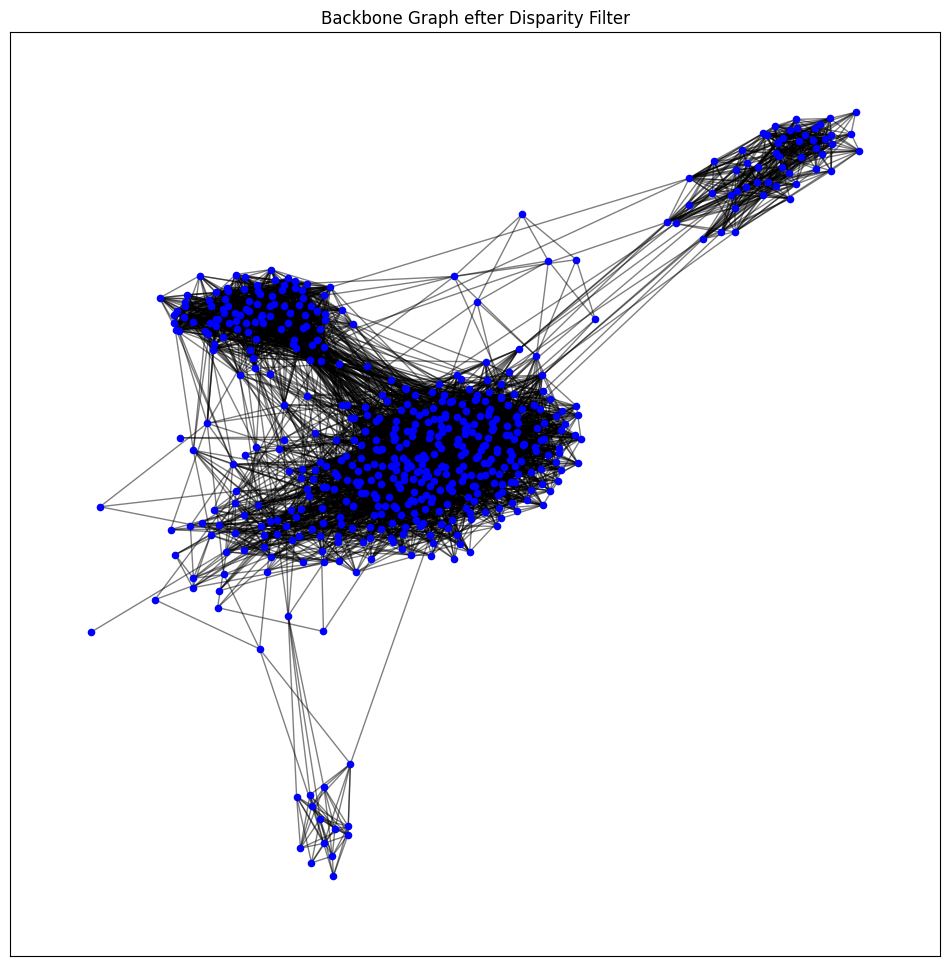

In [48]:
import networkx as nx
import math

def disparity_filter(G, alpha=0.05):
    """
    Extract backbone using the Disparity Filter method.
    G: weighted NetworkX graph
    alpha: significance threshold (default 0.05)
    Returns: backbone graph (NetworkX)
    """
    backbone = nx.Graph()
    backbone.add_nodes_from(G.nodes(data=True))

    for node in G.nodes():
        k = len(list(G.neighbors(node)))     # degree
        if k <= 1:
            # keep all edges for nodes with degree 1
            for nbr, data in G[node].items():
                backbone.add_edge(node, nbr, **data)
            continue

        # sum of incident weights
        w_sum = sum(data["weight"] for _, data in G[node].items())

        for nbr, data in G[node].items():
            w = data["weight"]
            p_ij = w / w_sum

            # Disparity Filter significance test
            alpha_ij = 1 - (1 - p_ij) ** (k - 1)

            if alpha_ij < alpha:
                # keep significant edge
                backbone.add_edge(node, nbr, **data)

    return backbone

# Anvend disparity filter på grafen H
backbone_H = disparity_filter(H, alpha=0.8)
print("\nBackbone graf efter Disparity Filter: {} noder, {} kanter".format(backbone_H.number_of_nodes(), backbone_H.number_of_edges()))

# plot
pos = nx.spring_layout(backbone_H, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(backbone_H, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(backbone_H, pos, alpha=0.5)
plt.title("Backbone Graph efter Disparity Filter")
plt.show()


In [40]:
import networkx as nx
from collections import defaultdict

def high_salience_skeleton(G, threshold=0.1, weight="weight"):
    """
    Extract backbone using the High Salience Skeleton method.
    
    G: weighted NetworkX graph
    threshold: salience threshold (0–1)
    weight: edge attribute used as distance
    
    Returns: backbone graph (NetworkX)
    """
    # Prepare salience counter
    salience = defaultdict(int)
    N = len(G.nodes())

    # Compute all-pairs shortest paths
    # For large graphs: this is expensive (O(N^3))
    for source in G.nodes():
        paths = nx.single_source_dijkstra_path(G, source, weight=weight)

        # Count edge usage
        for target, path in paths.items():
            if len(path) < 2:
                continue
            
            # For each edge in this shortest path, count usage
            for u, v in zip(path[:-1], path[1:]):
                if u < v:   # undirected normalization
                    salience[(u, v)] += 1
                else:
                    salience[(v, u)] += 1

    # Total number of paths = N*(N-1) / 2 for undirected
    total_paths = N * (N - 1) / 2

    # Build backbone graph
    backbone = nx.Graph()
    backbone.add_nodes_from(G.nodes(data=True))

    for (u, v), count in salience.items():
        S = count / total_paths   # salience score
        
        if S >= threshold:
            # copy attributes from original graph
            data = G[u][v]
            backbone.add_edge(u, v, **data, salience=S)

    return backbone


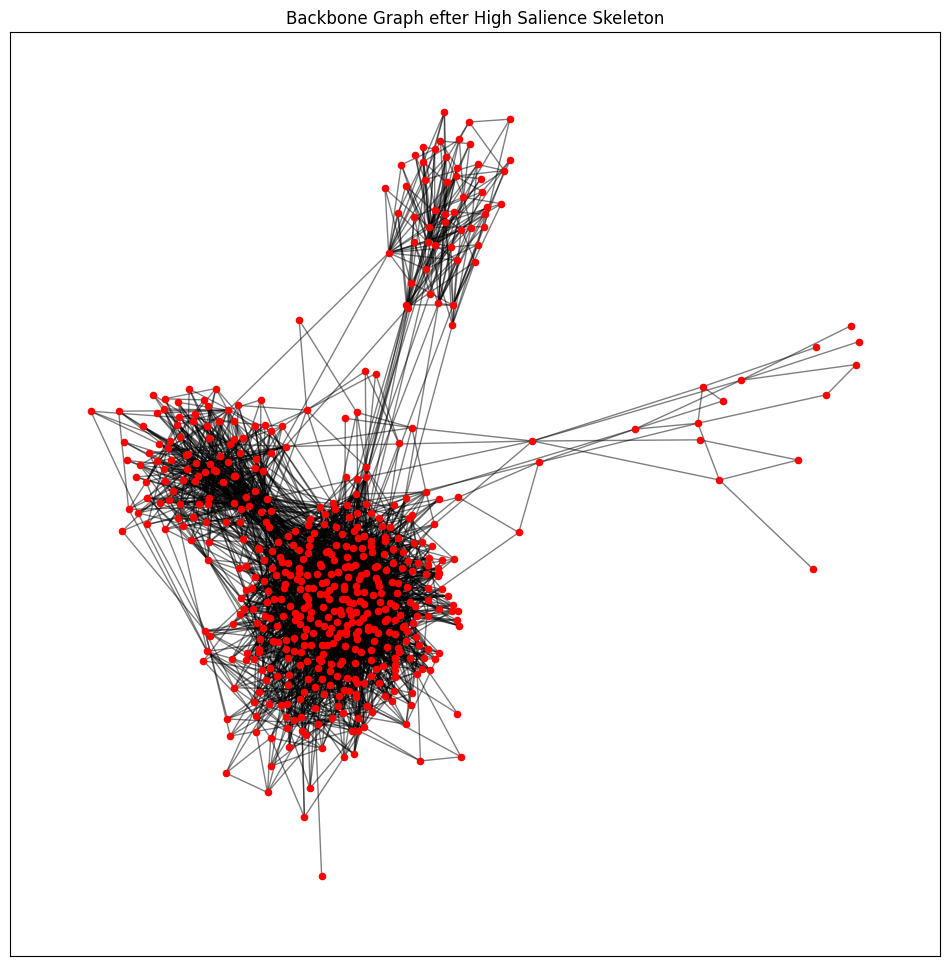

In [45]:
backbone_HSS = high_salience_skeleton(H, threshold=0.0005)
# Plot High Salience Skeleton backbone
pos = nx.spring_layout(backbone_HSS, seed=42)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(backbone_HSS, pos, node_size=20, node_color='red')
nx.draw_networkx_edges(backbone_HSS, pos, alpha=0.5)

plt.title("Backbone Graph efter High Salience Skeleton")
plt.show()
